In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video_retrieval import retrieve_closest_videos
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import yaml
import pandas as pd

In [3]:
with open('../config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

FEATS_PATH = config["FEATS_PATH"]
EMBEDDINGS_PATH = config["EMBEDDINGS_PATH"]

Functions that concatenate features of all three modalities.

In [4]:
def create_merged_df(video_feats, audio_feats, text_feats):
    
    df_audio = pd.read_csv(audio_feats)
    df_audio.drop_duplicates(subset='song_name', keep='first', inplace=True, ignore_index=True)
    df_text = pd.read_csv(text_feats)
    df_text.drop_duplicates(subset='song_name', keep='first', inplace=True, ignore_index=True)
    df_video = pd.read_csv(video_feats)
    df_video.drop_duplicates(subset='song_name', keep='first', inplace=True, ignore_index=True)

    data = pd.merge(df_video, df_audio, on='song_name')
    data = pd.merge(data, df_text, on='song_name')

    data = data.drop(['audio_path'], axis=1)
    
    return data

Get features without embeddings.

In [5]:
def initial_features(FEATS_PATH, pca=False):
    
    video_feats = FEATS_PATH + "\\video_feats.csv"
    audio_feats = FEATS_PATH + "\\audio_feats.csv"
    text_feats = FEATS_PATH + "\\lyrics_embeddings.csv"

    database = create_merged_df(video_feats, audio_feats, text_feats)

    video_feats = FEATS_PATH + "\\video_feats_test.csv"
    audio_feats = FEATS_PATH + "\\audio_feats_test.csv"
    text_feats = FEATS_PATH + "\\lyrics_embeddings_test.csv"

    query = create_merged_df(video_feats, audio_feats, text_feats)
    
    database_song_names = database.iloc[:,0]
    query_song_names = query.iloc[:,0]
     
    if pca:
        pca = PCA(n_components=256)
        database = pca.fit_transform(database.iloc[:,1:])  
        query = pca.transform(query.iloc[:,1:])

        database = pd.DataFrame(database)
        query = pd.DataFrame(query)

        database.insert(0,"song_name", database_song_names.to_list())
        query.insert(0,"song_name", query_song_names.to_list())
    
    q = query.iloc[0, 1:]

    # Get distance 
    cos_sim = cosine_similarity(database.iloc[:, 1:].values, q.values.reshape(1, -1))
    similarity_df = pd.DataFrame({'similarity': cos_sim.flatten(), 'index': database.index})
    sorted_df = similarity_df.sort_values(by='similarity', ascending=False)
    k = 5  
    top_k_rows = database.loc[sorted_df['index'].head(k)]

    print(f'Video clip: {query.iloc[0, 0]} similar to the following')
    print(top_k_rows.song_name)

## Query Examples

Initially, we retrieve the 5 most similar videos using our approach. Subsequently, we repeat the process without obtaining a latent representation, and then again after obtaining one using PCA. Our method outperforms the others.

**Video Clip 1** : *"Falling In Reverse - ZOMBIFIED"*

**AutoEncoder**

In [6]:
retrieve_closest_videos("Falling In Reverse - ZOMBIFIED")

[youtube] Extracting URL: https://www.youtube.com/watch?v=YDDz1Er2IXA
[youtube] YDDz1Er2IXA: Downloading webpage
[youtube] YDDz1Er2IXA: Downloading ios player API JSON
[youtube] YDDz1Er2IXA: Downloading android player API JSON
[youtube] YDDz1Er2IXA: Downloading m3u8 information
[info] YDDz1Er2IXA: Downloading 1 format(s): 625+140
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 43
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\Falling In Reverse - ＂ZOMBIFIED＂.f625.mp4
[download] 100% of  353.94MiB in 00:01:34 at 3.73MiB/s                     
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\Falling In Reverse - ＂ZOMBIFIED＂.f140.m4a
[download] 100% of    3.67MiB in 00:00:00 at 4.46MiB/s   
[Merger] Merging formats into "C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\Falling In Reverse - ＂ZOMBIFIED＂.mp4"
Deleting original file C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\Falling In R

Using cache found in C:\Users\tatbo/.cache\torch\hub\facebookresearch_pytorchvideo_main


Number of trainable parameters: 32454096

0
Device is: cuda:0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1, 257)
(821, 257)
Video clip: Falling In Reverse - ＂ZOMBI similar to the following
279    Disturbed - Another Way To Die [Official Music...
205    Avenged Sevenfold - Shepherd Of Fire [Official...
79     Social Distortion   Reach For The Sky (FMX Mus...
640                         WATERPARKS - RITUAL (VISUAL)
394              K.Flay - Raw Raw (Official Music Video)
Name: song_name, dtype: object


**Raw features**

In [7]:
initial_features(FEATS_PATH=FEATS_PATH)

Video clip: Falling In Reverse - ＂ZOMBI similar to the following
527                             Parklife (2012 Remaster)
543    Sonic Martini Music - User User User (Official...
551    The Calling - Wherever You Will Go (First Vide...
709          Sum 41 - In Too Deep (Official Music Video)
624                  Green Day - Hitchin' A Ride (Video)
Name: song_name, dtype: object


**PCA**

In [8]:
initial_features(FEATS_PATH=FEATS_PATH, pca=True)

Video clip: Falling In Reverse - ＂ZOMBI similar to the following
737    Yellowcard - Southern Air (+ Lyrics & HQ_HD Au...
543    Sonic Martini Music - User User User (Official...
496    Matchbox Twenty - Don't Get Me Wrong [Official...
184       Destiny's Child - Soldier ft. T.I., Lil' Wayne
201    Ice Cube, Mack 10, Ms. Toi - You Can Do It (Of...
Name: song_name, dtype: object


**Video 2** : *"STORMZY - LONGEVITY FLOW"*

**AutoEncoder**

In [9]:
retrieve_closest_videos("STORMZY - LONGEVITY FLOW")

[youtube] Extracting URL: https://www.youtube.com/watch?v=nuSGNTd5kCk
[youtube] nuSGNTd5kCk: Downloading webpage
[youtube] nuSGNTd5kCk: Downloading ios player API JSON
[youtube] nuSGNTd5kCk: Downloading android player API JSON
[youtube] nuSGNTd5kCk: Downloading m3u8 information
[info] nuSGNTd5kCk: Downloading 1 format(s): 625+140
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 38
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\STORMZY - LONGEVITY FLOW.f625.mp4
[download] 100% of  300.17MiB in 00:01:13 at 4.09MiB/s                     
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\STORMZY - LONGEVITY FLOW.f140.m4a
[download] 100% of    2.84MiB in 00:00:00 at 4.04MiB/s   
[Merger] Merging formats into "C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\STORMZY - LONGEVITY FLOW.mp4"
Deleting original file C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\STORMZY - LONGEVITY FLOW.f140.m4a (p

Using cache found in C:\Users\tatbo/.cache\torch\hub\facebookresearch_pytorchvideo_main


Number of trainable parameters: 32454096

0
Device is: cuda:0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1, 257)
(821, 257)
Video clip: STORMZY - LONGEVITY similar to the following
250           Central Cee - Retail Therapy [Music Video]
733                Mike Jones - Back Then Part 2 (Video)
617    Female Special - Plugged In w_ Fumez The Engin...
732    Cristale x Teezandos - Plugged In w_ Fumez The...
441    Ying Yang Twins - Salt Shaker (feat. Lil Jon &...
Name: song_name, dtype: object


**Raw features**

In [10]:
initial_features(FEATS_PATH=FEATS_PATH)

Video clip: STORMZY - LONGEVITY similar to the following
215                     Lloyd Banks - On Fire (Explicit)
118                          Old Dominion - One Man Band
531    Ricky Montgomery - Line Without a Hook (Offici...
160                  Baby Bash - Suga Suga ft. Frankie J
146    Zac Brown Band - Chicken Fried (Official Music...
Name: song_name, dtype: object


**PCA**

In [11]:
initial_features(FEATS_PATH=FEATS_PATH, pca=True)

Video clip: STORMZY - LONGEVITY similar to the following
531    Ricky Montgomery - Line Without a Hook (Offici...
160                  Baby Bash - Suga Suga ft. Frankie J
215                     Lloyd Banks - On Fire (Explicit)
47               Dan + Shay - Speechless (Wedding Video)
173    Chris Brown - Yo (Excuse Me Miss) (Official HD...
Name: song_name, dtype: object


**Video 3** : *"B.B. King - The Thrill Is Gone"*

**AutoEncoder**

In [12]:
retrieve_closest_videos("B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live Video)")

[youtube] Extracting URL: https://www.youtube.com/watch?v=SgXSomPE_FY
[youtube] SgXSomPE_FY: Downloading webpage
[youtube] SgXSomPE_FY: Downloading ios player API JSON
[youtube] SgXSomPE_FY: Downloading android player API JSON
[youtube] SgXSomPE_FY: Downloading m3u8 information
[info] SgXSomPE_FY: Downloading 1 format(s): 133+140
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live Video).f133.mp4
[download] 100% of    7.71MiB in 00:00:02 at 3.60MiB/s   
[download] Destination: C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live Video).f140.m4a
[download] 100% of   10.28MiB in 00:00:02 at 3.60MiB/s   
[Merger] Merging formats into "C:\Users\tatbo\PycharmProjects\Multimodal\data\data_test\B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live Video).mp4"
Deleting original file C:\Users\tatbo\PycharmProjects\Multimodal\d

Using cache found in C:\Users\tatbo/.cache\torch\hub\facebookresearch_pytorchvideo_main


Number of trainable parameters: 32454096

0
Device is: cuda:0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1, 257)
(821, 257)
Video clip: B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live V similar to the following
504            Georgia field hands - Mary Don't You Weep
381                   Tyler Childers _ Feathered Indians
613                    Muddy Waters - Crawlin King Snake
180    Disturbed - The Sound of Silence [Live in Daws...
173    The Midnight Sons Band - Brother - CD Release ...
Name: song_name, dtype: object


**Raw features**

In [13]:
initial_features(FEATS_PATH=FEATS_PATH)

Video clip: B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live V similar to the following
262                                      Bonnie's Lounge
603    Bloodhound Gang - Fire Water Burn (Official Vi...
58     George Strait - Check Yes Or No (Official Musi...
769          The Stylistics - You Make Me Feel Brand New
395                                  The Sheepdogs - Who
Name: song_name, dtype: object


**PCA**

In [14]:
initial_features(FEATS_PATH=FEATS_PATH, pca=True)

Video clip: B.B. King - The Thrill Is Gone [Crossroads 2010] (Official Live V similar to the following
1                               Bukka White - Miss Leola
8                 Mississippi Fred McDowell - John Henry
742    Bobby Womack - If You Think You're Lonely Now ...
769          The Stylistics - You Make Me Feel Brand New
747                        Dells - Oh What a Night -1969
Name: song_name, dtype: object


## Clustering of Latent Space

In [108]:
embeddings = pd.read_csv(EMBEDDINGS_PATH)

In [109]:
def cosine_distance(x,y):
    return 1-cosine_similarity(x,y)

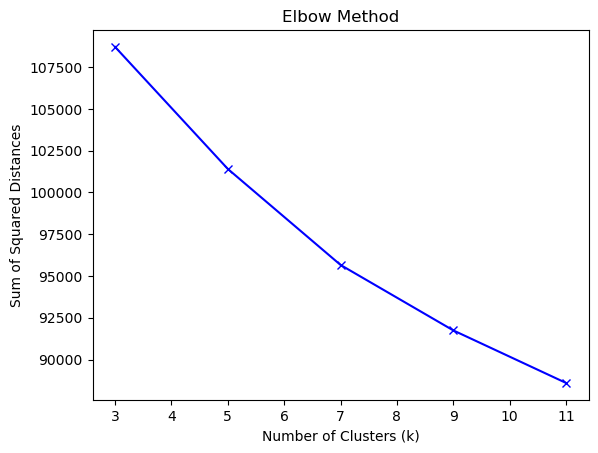

In [110]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

embeddings_n = embeddings.iloc[:,1:]

# Perform K-means clustering for different values of k
k_values = [3,5,7,9,11]
squared_distances = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embeddings_n)
    squared_distance = kmeans.inertia_
    squared_distances.append(squared_distance)

# Plot the Elbow curve
plt.plot(k_values, squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

Run k-means using "best" number of clusters

In [111]:
kmeans = KMeans(n_clusters=9)
labels = kmeans.fit_predict(embeddings_n)
squared_distance = kmeans.inertia_
squared_distances.append(squared_distance)

In [112]:
labels = labels+1
labels = list(labels)

In [113]:
# Sample 10 samples from each cluster
samples_per_cluster = 5
cluster_samples = []

embeddings_n.insert(0,"cluster", labels)
embeddings_n.insert(0,"song_name", embeddings.iloc[:,0].to_list())

,song_name,cluster,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,Thomas Rhett - Die A Happy Man,4,0.807214,0.633600,-0.062627,-0.078656,0.993487,0.657096,-0.626063,-0.979378,...,0.541554,0.026644,-0.993699,-0.987344,0.648988,-0.849688,-0.626969,0.978708,-0.371957,0.226474
1,TILT - Libel,3,-0.973501,-0.948540,0.970880,-0.913761,-0.971901,0.811839,-0.233491,-0.004211,...,0.074896,-0.709221,0.563030,0.999122,-0.831629,-0.099273,0.998546,-0.937544,-0.854960,0.883611
2,Shania Twain - Forever And For Always (Red Ver...,2,0.980960,0.121789,0.754204,-0.819493,0.996373,0.976396,-0.717270,-0.980906,...,-0.364673,-0.980262,-0.950821,0.701570,0.777032,-0.688415,-0.273060,0.962199,0.945031,-0.989199
3,Nelly - Hot In Herre (Official Music Video),6,-0.609121,0.638765,-0.804273,0.234387,0.938752,-0.974341,0.901054,0.871889,...,-0.988430,-0.971482,0.982967,-0.959022,0.890857,0.230073,-0.600256,0.414989,0.492938,-0.782129
4,LL COOL J - Headsprung,6,-0.309150,-0.718403,-0.720790,0.111536,-0.654834,0.966190,0.742143,0.970588,...,-0.947098,-0.993651,0.908819,0.899161,0.649585,-0.751321,-0.751324,0.669397,0.775072,-0.497838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,"Outkast - So Fresh, So Clean (Official HD Video)",6,0.396298,-0.967212,-0.754197,-0.199249,0.998496,-0.654552,0.878481,0.959535,...,-0.965482,-0.997359,-0.750276,0.129609,0.999449,-0.542297,-0.689597,0.993187,-0.953951,-0.786377
817,Ricky Montgomery - Line Without a Hook (Offici...,8,0.398780,0.992601,0.037728,0.991507,0.961053,0.785508,0.990429,0.544638,...,-0.771716,0.510719,-0.956835,0.671504,-0.912616,0.973872,0.755712,-0.998973,0.950326,0.026741
818,Megadeth - Public Enemy No. 1 [OFFICIAL HD VIDEO],3,0.978117,0.056075,-0.925701,0.997622,-0.320415,0.979800,0.167090,0.986704,...,0.470602,-0.665816,-0.997346,0.720644,0.953972,0.541473,0.641372,0.918582,-0.184970,0.937790
819,Shakira - Waka Waka (This Time for Africa) (Th...,9,-0.921554,-0.919587,-0.281537,-0.997949,0.375196,-0.990848,-0.928050,-0.649428,...,-0.969228,0.606279,0.989357,-0.960620,-0.343322,-0.497437,-0.374505,0.995391,0.888542,-0.898463


In [114]:
embeddings_n.groupby("cluster").count()["song_name"]

cluster
1     72
2    109
3    110
4    101
5     74
6    105
7     77
8     78
9     95
Name: song_name, dtype: int64

In [123]:
columns = ['song_name']
sampled_df = embeddings_n.groupby("cluster").apply(lambda x: x.sample(5))[columns]

sampled_df

song_name
cluster                                                       
1       695  Luke Bryan - Roller Coaster (Official Music Vi...
        57                          Choking Victim - War Story
        111         Craig Cardiff - Emm & May (Official Video)
        393  Coldplay - Adventure Of A Lifetime (Official V...
        626        Murray McLauchlan _ Down by the Henry Moore
2       667  Billy Ray Cyrus - Achy Breaky Heart (Official ...
        436                            One Direction - You & I
        253  Chris Young - The Man I Want To Be (Official V...
        820  Sam Smith - Stay With Me ft. Mary J. Blige (Live)
        402  Maddie & Tae - Die From A Broken Heart (Offici...
3       351  (OOAK) Russ Millions x Buni x YV - Reggae & Ca...
        132  Florence + The Machine - Dog Days Are Over (20...
        407                       Pennywise - 'Same Old Story'
        541   Coldplay - Hymn For The Weekend (Official Video)
        760             Sly Slick and Wicked - Somebody Please
4       440  Hate It Too - 'Twelve's the New Eight' Officia...
        794  Counting Crows - Mr. Jones (Official Music Video)
        23                  DragonForce - Three Hammers (Live)
        379                           OutKast -- Hey Ya lyrics
        121  Chris Lane - I Don't Know About You (Official ...
5       750  Grey Kingdom 'Sun Like Moon Light' - www.strea...
        590                 Madison Violet - Small Of My Heart
        67                     Johnny Flynn - Raising the Dead
        502  Mystery Train _ Playing For Change _ Live Outside
        237                           Bukka White - Miss Leola
6       20             Huey - Pop, Lock & Drop It (Video Edit)
        41               50 Cent - Outta Control ft. Mobb Deep
        722         Lil Wayne - Fireman (Official Music Video)
        360              Eminem - Stan (Long Version) ft. Dido
        391  Ludacris - Rollout (My Business) (Official Mus...
7       19        Blur - Girls And Boys (Official Music Video)
        250         Central Cee - Retail Therapy [Music Video]
        725                      The Struts - Kiss This (2014)
        362  Matchbox Twenty - Wild Dogs (Running in a Slow...
        129  Steel Panther - Party Like Tomorrow Is The End...
8       758  Morgan Evans - Over For You (Official Music Vi...
        526  Kelsie Kimberlin -  Cosmopolitan Girl _ #stand...
        245  Queens Of The Stone Age - No One Knows (Offici...
        373  You Are The First, My Last, My Everything (Bar...
        336  Maroon 5 - Won't Go Home Without You (Official...
9       329    Motörhead – God Save The Queen (Official Video)
        18   Foo Fighters - Best Of You (Official Music Video)
        423                     Jet - Are You Gonna Be My Girl
        170                   Sex Pistols - God Save The Queen
        782                 Social Distortion - Ball and Chain